# ECE 670 X1 Mini Project 1

## Task 1 - Mosquito Trap Data and Weather Data

<b>Problem Statement</b>

For Task 1, we were tasked in the creation of 3 regression models using Edmonton weather data and Edmonton Mosquito Trap data. These models were meant to represent a function between the number of observed mosquitoes when considering a number of weather features.

In total, 3 models were created:
1. A linear regression model to represent the number of observed mosquitoes given a number of weather features. 
2. A linear regression model to represent the number of female mosquitoes given the same weather data.
3. A polynomial model to model the number of female mosquitoes given the same weather data.

### Data Pre-processing

Prior to creation of a linear regression model, both data sets (Edmonton Mosquito Trap Data and Edmonton Weather Data) had to be concatenated into a singular data set for analysis. During the initial inspection of the data, the following was observed:
1. Additional logic had to be added to resolve the 'time grid' utilized by the two sets of data. Where the Mosquito Trap Data was sampled at a frequency of one data point per week, Edmonton Weather data was sampled once every hour. 
2. Because Edmonton weather data is an instantaneous measure at the recorded time, some kind of aggregation of the weather data is desired to better match the Mosquito Trap data, such as the utilization and calculation of a moving average for certain features in the weather data set (humidity, temp, dew point, wind_dir_10s, wind_speed, health_index)
3. Within both data sets, some features have inconsistent data and therefore was ignored from the analysis. Columns with limited or no data, such as visibility, cloud cover, humidex, windchill and solar radiation were identified as unncessary to our analysis, and was removed. Similarly, rows with missing data points were also removed from our analysis.
4. For the Edmonton Mosquito Trap data, rows marked with UnID from the IDd column represented bad data and were removed from the analysis. 

<b>Mosquito Data Pre-processing</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper_functions

In [2]:
mosquito_df = pd.read_csv('data_files/Mosquito_Trap_Data.csv')
weather_df = pd.read_csv('data_files/weather_stats_edmonton.csv')

In [3]:
mosquito_df_prep = helper_functions.clean_mosquito_df(mosquito_df, gender=None) # both male and female combined
weather_df_prep = helper_functions.clean_weather_df(weather_df)
weather_df_prep = helper_functions.preprocess_weather(weather_df_prep, ['2D', '7D', '14D'])

<b>Concatenation of the Two Data Sets</b>

In [4]:
merged_df = helper_functions.merge_mosquito_weather_data(mosquito_df_prep, weather_df_prep)


Index(['Count', 'pressure_station', 'pressure_sea', 'wind_dir_10s',
       'wind_speed', 'wind_gust', 'relative_humidity', 'dew_point',
       'temperature', 'pressure_station_2D', 'pressure_station_7D',
       'pressure_station_14D', 'pressure_sea_2D', 'pressure_sea_7D',
       'pressure_sea_14D', 'wind_dir_10s_2D', 'wind_dir_10s_7D',
       'wind_dir_10s_14D', 'wind_speed_2D', 'wind_speed_7D', 'wind_speed_14D',
       'relative_humidity_2D', 'relative_humidity_7D', 'relative_humidity_14D',
       'dew_point_2D', 'dew_point_7D', 'dew_point_14D', 'temperature_2D',
       'temperature_7D', 'temperature_14D'],
      dtype='object')

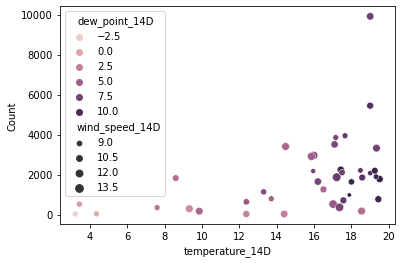

In [14]:
sns.scatterplot(data=merged_df, x='temperature_14D', y='Count', hue='dew_point_14D', size='wind_speed_14D')

merged_df.columns

In [19]:
# Split data into sx and y:
X = merged_df.iloc[:, 1:].values
y = merged_df.iloc[:, :1].values

array([[  26],
       [  29],
       [ 523],
       [ 360],
       [1649],
       [2959],
       [1868],
       [ 767],
       [1776],
       [2242],
       [1634],
       [ 978],
       [ 724],
       [ 711],
       [2107],
       [3944],
       [3854],
       [ 791],
       [1825],
       [ 168],
       [ 292],
       [ 173],
       [1256],
       [3405],
       [2909],
       [9918],
       [3322],
       [3511],
       [1851],
       [5446],
       [2072],
       [1895],
       [2193],
       [2207],
       [2177],
       [1134],
       [ 636],
       [ 344],
       [ 518],
       [  33],
       [  28]])

### Regression Models

<b>Model A: Number of Mosquitoes vs. Weather Features (Linear Regression)</b>

In [24]:
from sklearn import linear_model#%%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import helper_functions

In [ ]:
mosquito_df = pd.read_csv('data_files/Mosquito_Trap_Data.csv')
weather_df = pd.read_csv('data_files/weather_stats_edmonton.csv')

In [ ]:
mosquito_df_prep = helper_functions.clean_mosquito_df(mosquito_df, gender=None) # both male and female combined
weather_df_prep = helper_functions.clean_weather_df(weather_df)
weather_df_prep = helper_functions.preprocess_weather(weather_df_prep, ['2D', '7D', '14D'])

merged_df = helper_functions.merge_mosquito_weather_data(mosquito_df_prep, weather_df_prep)

In [52]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

normalized_df = merged_df.copy()
scaler = StandardScaler()
normalized_df.loc[:,:] = scaler.fit_transform(normalized_df)

In [53]:
normalized_df

,Count,pressure_station,pressure_sea,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,pressure_station_2D,...,wind_speed_14D,relative_humidity_2D,relative_humidity_7D,relative_humidity_14D,dew_point_2D,dew_point_7D,dew_point_14D,temperature_2D,temperature_7D,temperature_14D
Trap Date,,,,,,,,,,,,,,,,,,,,,
2017-05-09,-0.987088,0.021967,0.156240,0.455486,-0.416650,-0.643268,-1.095767,-2.237777,-0.255689,0.103120,...,0.222259,-1.164603,-0.121120,-0.562478,-1.563119,-1.074486,-1.207486,-0.364269,-0.778627,-0.650988
2017-05-16,-0.985429,-1.058787,-0.934117,-1.681446,1.162418,-0.643268,0.969175,-0.469598,-1.566096,-0.241959,...,0.687712,1.024467,-0.769657,-1.261925,-1.259644,-1.462973,-1.133189,-1.980261,-0.649166,-0.196323
2017-05-23,-0.712267,0.562343,0.428829,0.176756,-0.847304,-0.643268,-0.928339,-0.494156,0.775164,-2.192790,...,1.775639,-0.593345,-1.315174,-1.247384,-0.225097,-0.923487,-0.345049,0.601477,0.136723,0.389617
2017-05-30,-0.802400,0.907584,0.837713,-1.309806,-0.273098,-0.643268,-1.039957,-1.427361,0.198585,-0.254029,...,1.768162,-1.626406,-0.744833,-0.622461,-0.792256,0.138826,0.171017,0.854064,0.530473,0.466517
2017-06-06,-0.089634,0.502301,0.428829,0.734216,0.875315,1.554563,-0.928339,-1.132665,0.233529,0.643460,...,0.517607,-1.322036,-0.248345,-0.084425,-0.586178,0.125357,0.198835,0.731526,0.291540,0.207498
2017-06-13,0.634745,-1.343986,-1.343001,-0.473615,0.588211,-0.643268,-0.481865,0.512724,0.792637,-0.998505,...,1.388696,0.787568,0.173670,-0.409792,1.011965,0.195362,0.006465,0.078462,0.009006,0.158520
2017-06-20,0.031465,0.247124,0.292535,-0.287795,-0.703753,-0.643268,-0.593484,-0.420482,0.268474,-0.636740,...,1.970045,-0.188517,-0.803791,-0.203302,-0.147892,-0.265611,0.486691,-0.051587,0.192935,0.432865
2017-06-27,-0.577345,-1.674216,-1.751885,-1.588536,-1.421511,-0.643268,-0.816720,0.831978,1.648769,-1.553756,...,0.145618,0.867034,0.526177,-0.105510,0.842114,1.171365,1.165653,-0.157223,0.561329,0.931777
2017-07-04,-0.019408,-0.128138,-0.116349,0.734216,0.588211,-0.643268,0.355273,0.610956,-0.203273,0.271754,...,0.285815,-1.020664,-0.636847,0.001734,-0.231036,1.114297,1.292359,0.639036,1.197366,0.947903


In [35]:
cols_sel = ['pressure_station', 'pressure_sea', 'wind_dir_10s', 'wind_speed',
            'wind_gust', 'relative_humidity', 'dew_point', 'temperature']
cols_pressure_station = ['pressure_station_2D', 'pressure_station_7D', 'pressure_station_14D']
cols_pressure_sea = ['pressure_sea_2D', 'pressure_sea_7D', 'pressure_sea_14D']
cols_wind_dir = ['wind_dir_10s_2D', 'wind_dir_10s_7D', 'wind_dir_10s_14D']
cols_wind_speed = ['wind_speed_2D', 'wind_speed_7D', 'wind_speed_14D']
cols_relative_humidity = ['relative_humidity_2D', 'relative_humidity_7D', 'relative_humidity_14D']
cols_dew_point = ['dew_point_2D', 'dew_point_7D', 'dew_point_14D']
cols_temp = ['temperature_2D', 'temperature_7D', 'temperature_14D']

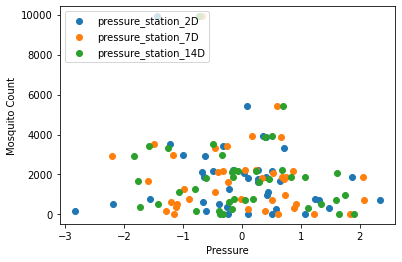

In [54]:
fig, axes = plt.subplots()
for feature in cols_pressure_station:
    plt.scatter(normalized_df[feature], merged_df['Count'], axes=axes, label=feature)
axes.set_xlabel('Pressure')
axes.set_ylabel('Mosquito Count')
axes.legend(loc='upper left')

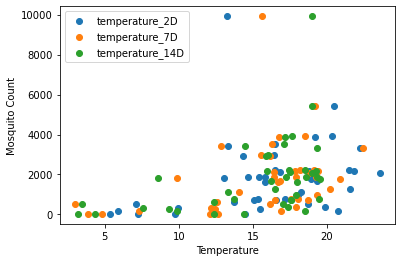

In [47]:
fig, axes = plt.subplots()
for feature in cols_temp:
    plt.scatter(merged_df[feature], merged_df['Count'], axes=axes, label=feature)
axes.set_xlabel('Temperature')
axes.set_ylabel('Mosquito Count')
axes.legend(loc='upper left')

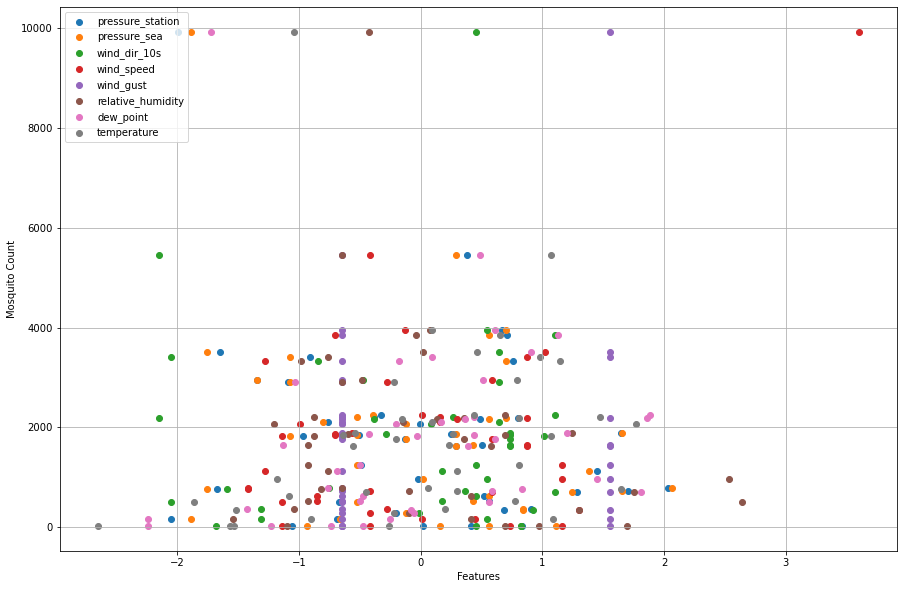

In [57]:
fig, axes = plt.subplots(figsize=(15,10))
for feature in cols_sel:
    plt.scatter(normalized_df[feature], merged_df['Count'], axes=axes, label=feature)
axes.set_xlabel('Features')
axes.set_ylabel('Mosquito Count')
plt.grid()
axes.legend(loc='upper left')

In [ ]:
sns.scatterplot(data=merged_df, x='temperature_14D', y='Count', hue='dew_point_14D', size='wind_speed_14D')

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression, SelectKBest,

lreg = linear_model.LinearRegression()

In [27]:
score_lreg = cross_val_score(lreg, X, y, cv=3, verbose=1)
predictions = cross_val_predict(lreg, X, y, cv=3, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


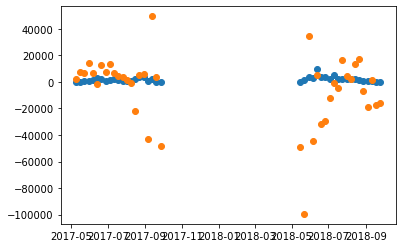

In [30]:
plt.scatter(merged_df.index, y)
plt.scatter(merged_df.index, predictions)

In [ ]:
wsk = lreg.intercept_,lreg.coef_[0]
wsk

In [ ]:
plt.scatter(X,Y)
plt.plot(X,wsk[0]+wsk[1]*X,'r')
plt.plot(X,w[0]+w[1]*X,'g');

In [ ]:
Y_pred_sk = sklreg.predict(X_test)

In [ ]:
plt.scatter(X_test , Y_test)
plt.plot(X_test , Y_pred_sk, 'g', label='scikit-learn');
plt.legend();

In [ ]:
cost_test_sk = linreg.cost_function(Features, Y_test, wsk)
cost_test_sk

In [ ]:
score_train_sk = sklreg.score(X_train,Y_train)
score_test_sk = sklreg.score(X_test,Y_test)
score_train_sk, score_test_sk

<b>Model B: Number of Female Mosquitos vs. Weather Features (Linear Regression)</b>

In [ ]:
data = pd.read_csv('data/Advertising.csv')
X = data.loc[:,['radio','TV']].values
Y = data['sales'].values.reshape(len(X),1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X , Y , test_size = 0.3, random_state = 0)

In [ ]:
import linear_regression as linreg
%time w, h, w_h = linreg.train(X_train,Y_train, 0.00001, 200000)

In [ ]:
plt.plot(h);

In [ ]:
sklreg = linear_model.LinearRegression()
sklreg.fit(X_train,Y_train)

In [ ]:
# Using Standardization
from sklearn.preprocessing import StandardScaler
X_train_scaled = StandardScaler().fit_transform(X_train)

sklreg.fit(X_train_scaled, Y_train)

In [ ]:
wsk = [sklreg.intercept_[0],sklreg.coef_[0][0],sklreg.coef_[0][1]]

In [ ]:
bias = np.ones(shape=(len(X_test),1))
Features = np.append(bias, X_test, axis=1)
Y_pred = linreg.predict(Features,w)

In [ ]:
Y_pred_sk = sklreg.predict(X_test)

In [ ]:
import pandas as pd
pd.DataFrame({'':['Widthout normalization','With normalization','With standarization','scikit-learn'],
              'Train score':[score(X_train, Y_train, w),
                             score(X_train_norm, Y_train, w_n),
                             score(X_train_std, Y_train, w_s),
                             sklreg.score(X_train,Y_train)],
              'Test score':[score(X_test, Y_test, w),
                            score(normalization(X_test), Y_test, w_n),
                            score(standardization(X_test), Y_test, w_s),
                            sklreg.score(X_test,Y_test)]})

<b>Model C: Number of Female Mosquitos vs. Weather Features (Polynomial Regression)</b>

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)

sklreg_poly = linear_model.LinearRegression()
sklreg_poly.fit(X_train_poly,Y_train)

Xl = np.linspace(0, 1, 100).reshape(100,1)
Xl_poly = poly_features.fit_transform(Xl)

Y_pred = sklreg_poly.predict(Xl_poly)
plt.scatter(X_train,Y_train)
plt.plot(Xl,Y_pred,'r');

sklreg_poly.score(X_train_poly,Y_train),sklreg_poly.score(poly_features.fit_transform(X_test),Y_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def plot_models(X,Y,X_test, Y_test, degrees):
    for i,degree in enumerate(degrees):
        ax = plt.subplot(1, len(degrees), i + 1)
        poly_features = PolynomialFeatures(degree=degree)
        sklreg = linear_model.LinearRegression()
        pipeline = Pipeline([("polynomial_features", poly_features),
                             ("linear_regression", sklreg)])
        pipeline.fit(X,Y)
        Y_pred = pipeline.predict(X)
        plt.plot(X_test, pipeline.predict(X_test), label="Model")
        plt.scatter(X, Y, edgecolor='b', s=20, label="Samples")
        plt.scatter(X_test, Y_test, edgecolor='r',s=15, label="Test")
        plt.xlabel("x")
        plt.title("Degree {}".format(degree))
        plt.legend(loc="best")

In [ ]:
plt.figure(figsize=(14, 5))
plot_models(X_train,Y_train,X_test,Y_test,[1,2,9])

<b>Feature Selection</b>

In [ ]:
from sklearn.feature_selection import f_regression

data = pd.read_csv('data/Advertising.csv')
X = data.loc[:,['radio','TV','newspaper']].values
Y = data['sales'].values

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [ ]:
F_test,p_value = f_regression(X_poly,Y)
pd.DataFrame({'feature':poly_features.get_feature_names(),
              'F_test':F_test,'p_value':p_value})

In [ ]:
from sklearn.feature_selection import SelectKBest

X_best = SelectKBest(f_regression,5).fit_transform(X_poly, Y)

In [ ]:
X_poly.shape, X_best.shape



